# Fireworks Safe Zones - Interactive Analysis

Interactive analysis and visualization of safe zones for fireworks in any city.

This notebook uses the **current API** with differentiated buffers (20-300m) for 39 obstacle categories.

**Supports any city worldwide via OpenStreetMap!**

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as cx

from src.osm_loader import get_city_boundary, load_all_obstacles
from src.geometry_utils import create_forbidden_zone_with_custom_buffers
from src.zones_generator import create_zones_from_free_space, add_zone_metadata, classify_zones_by_size
from src.config import get_buffer_distances, get_category_configs, get_utm_crs_for_location, DEFAULT_MIN_ZONE_AREA_M2

# Configure matplotlib for Retina displays in Jupyter
%config InlineBackend.figure_format = 'retina'

# Configure city to analyze
CITY = "Yerevan, Armenia"  # Change to any city: "Prague, Czech Republic", "Tbilisi, Georgia", etc.

print("Modules loaded successfully")
print(f"City configured: {CITY}")
print("Retina display support: enabled")

Modules loaded successfully
City configured: Yerevan, Armenia
Retina display support: enabled


## Configuration

In [2]:
# Analysis parameters
MIN_ZONE_AREA = DEFAULT_MIN_ZONE_AREA_M2  # 2000 m²

print("Configuration:")
print(f"  City: {CITY}")
print(f"  Minimum zone area: {MIN_ZONE_AREA:,} m²")

# Show buffer configuration
buffers = get_buffer_distances()
print(f"\nBuffer distances: {len(buffers)} categories")
print(f"  Range: {min(buffers.values()):.0f}m - {max(buffers.values()):.0f}m")

Configuration:
  City: Yerevan, Armenia
  Minimum zone area: 2,000.0 m²

Buffer distances: 41 categories
  Range: 20m - 1500m


## Load Data

This may take 2-3 minutes on first run (OSMnx caches data).

In [3]:
print(f"Loading boundary for '{CITY}'...")
boundary = get_city_boundary(CITY)

print("Boundary loaded:")
print(f"  CRS: {boundary.crs}")

# Auto-detect UTM zone
print("\nDetecting UTM zone...")
TARGET_CRS = get_utm_crs_for_location(boundary)
print(f"  Using {TARGET_CRS} for calculations")

# Calculate area in UTM (correct projection)
boundary_utm = boundary.to_crs(TARGET_CRS)
boundary_area_km2 = boundary_utm.geometry.area.sum() / 1_000_000
print(f"  Area: {boundary_area_km2:.2f} km²")

Loading boundary for 'Yerevan, Armenia'...
Boundary loaded:
  CRS: epsg:4326

Detecting UTM zone...
  Using EPSG:32638 for calculations
  Area: 225.79 km²


In [4]:
print("Loading obstacles from OpenStreetMap...")
print("  (This may take 2-3 minutes)\n")

obstacles = load_all_obstacles(
    boundary,
    include_sensitive=True,
    split_sensitive=True
)

total_features = sum(len(gdf) for gdf in obstacles.values())
non_empty_cats = sum(1 for gdf in obstacles.values() if len(gdf) > 0)

print("\nObstacles loaded:")
print(f"  Total features: {total_features:,}")
print(f"  Active categories: {non_empty_cats}/{len(obstacles)}")

Loading obstacles from OpenStreetMap...
  (This may take 2-3 minutes)



Loading buildings   :   0%|                                                | 0/6 [00:00<?, ?layer/s]

Loading sensitive   :  67%|██████████████████████████▋             | 4/6 [00:06<00:02,  1.07s/layer]

Loading sensitive   : 100%|████████████████████████████████████████| 6/6 [00:08<00:00,  1.36s/layer]


Obstacles loaded:
  Total features: 85,201
  Active categories: 38/41


## Obstacle Statistics

In [5]:
# Create statistics table
configs = get_category_configs()
stats = []

for name, gdf in obstacles.items():
    if len(gdf) > 0 and name in configs:
        stats.append({
            'category': name,
            'count': len(gdf),
            'buffer_m': configs[name]['buffer_m'],
            'description': configs[name]['description']
        })

stats_df = pd.DataFrame(stats).sort_values('count', ascending=False)

print("Top 15 obstacle categories by count:\n")
print(stats_df.head(15).to_string(index=False))

Top 15 obstacle categories by count:

        category  count  buffer_m                                                         description
       buildings  75757      30.0                                             All building structures
           roads   3704      30.0                                            Major roads and highways
           parks    926      30.0                  Parks, gardens, playgrounds, and sports facilities
         parking    776      50.0                                              Parking lots and areas
commercial_areas    670      30.0                     Commercial zones, shops, restaurants, and cafes
         forests    548      30.0                  Forests, woods, and tree-covered areas (fire risk)
       waterways    368      20.0                       Rivers, streams, canals (e.g., Hrazdan River)
        railways    315      50.0 Railway infrastructure (stations, tracks, platforms, yards, depots)
         garages    271      20.0           

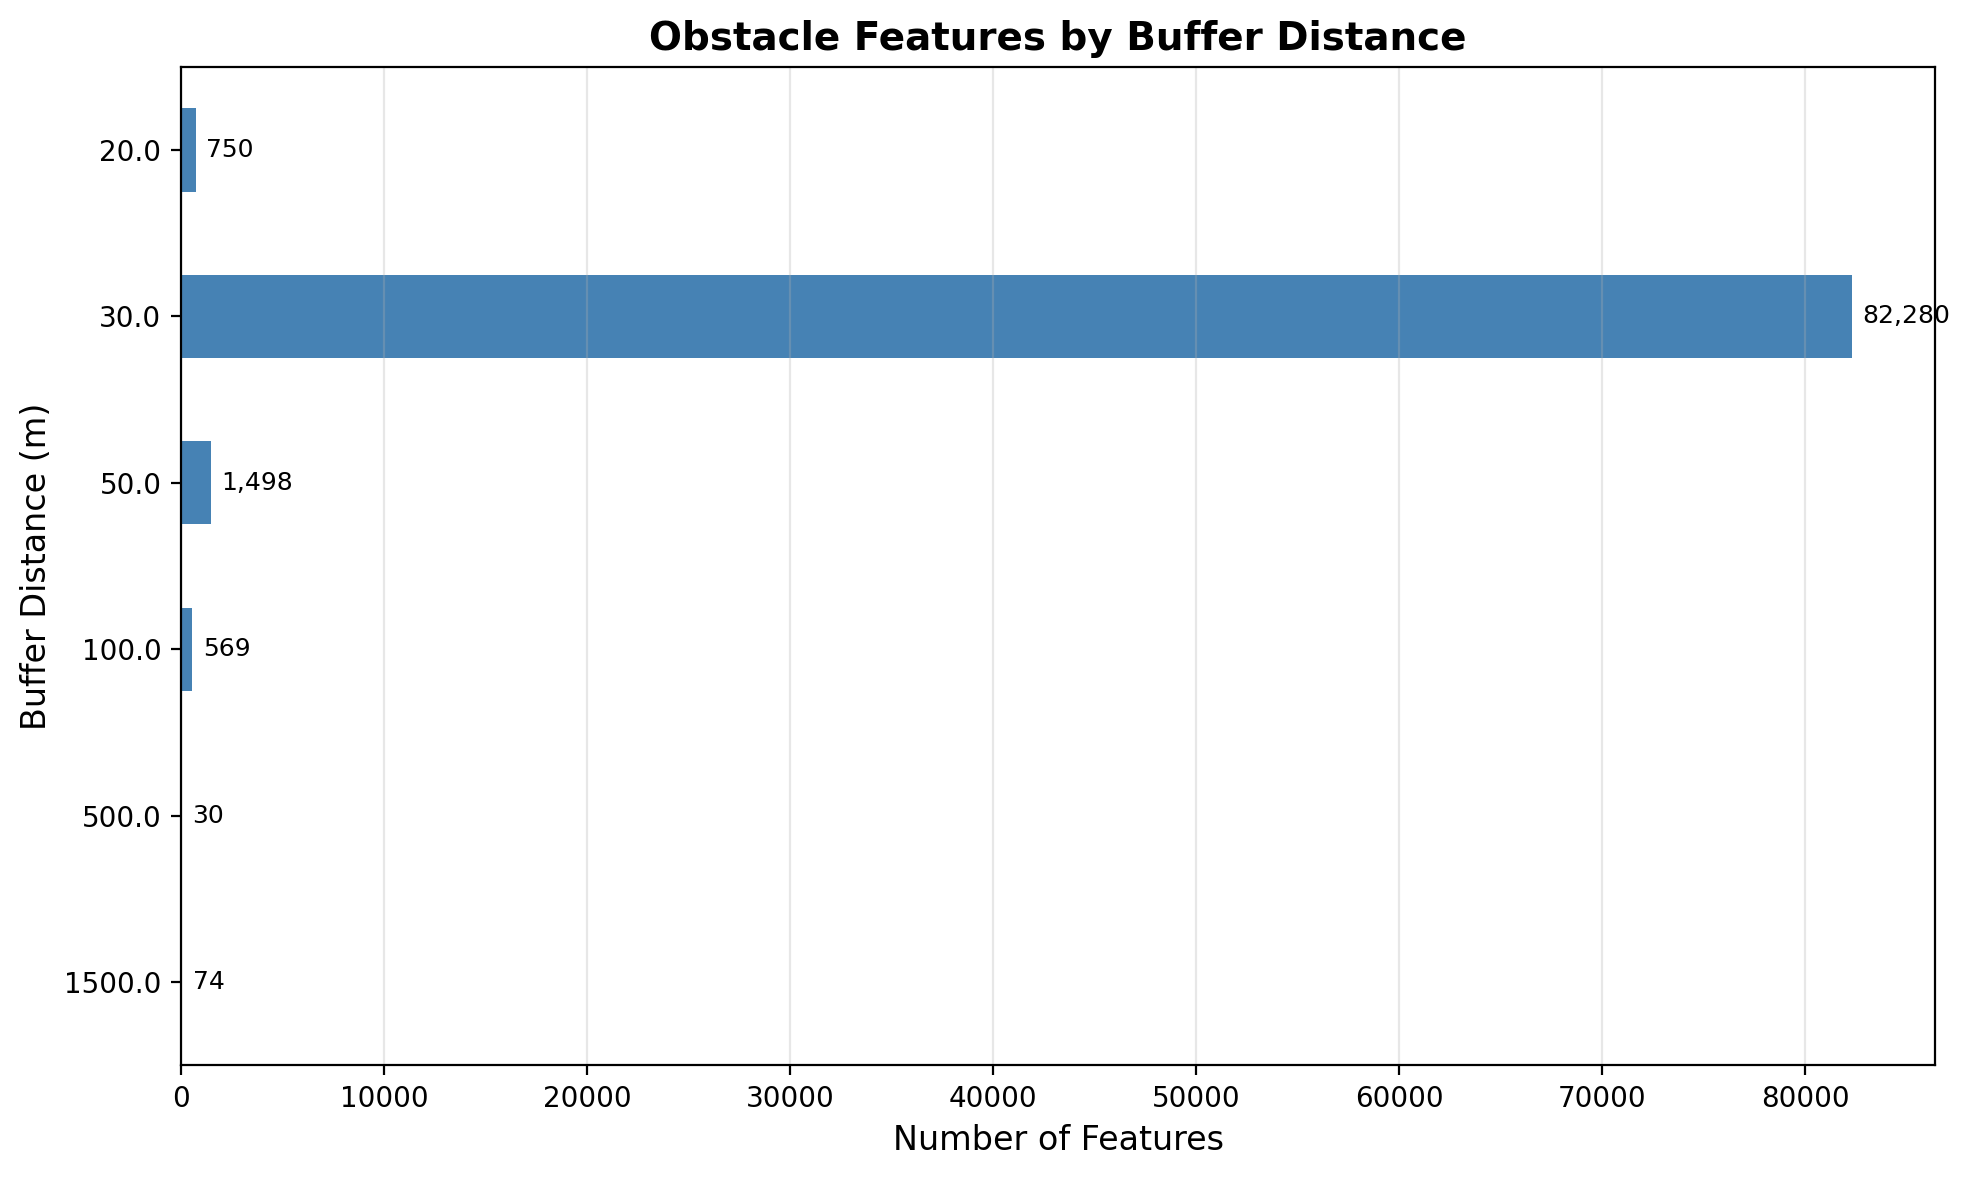

In [6]:
# Visualize obstacles by buffer distance
buffer_groups = stats_df.groupby('buffer_m')['count'].sum().sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
buffer_groups.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Features', fontsize=12)
ax.set_ylabel('Buffer Distance (m)', fontsize=12)
ax.set_title('Obstacle Features by Buffer Distance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(buffer_groups.values):
    ax.text(v + 500, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Generate Safe Zones

In [7]:
print("Creating forbidden zone with differentiated buffers...")
buffers = get_buffer_distances()
forbidden_zone, target_crs = create_forbidden_zone_with_custom_buffers(obstacles, TARGET_CRS, buffers)

print("Forbidden zone created")

Creating forbidden zone with differentiated buffers...


Buffering garages         (20.0m): 100%|██████████████████████████| 38/38 [00:02<00:00, 16.22type/s]


Forbidden zone created


In [8]:
print(f"Generating safe zones (min area: {MIN_ZONE_AREA:,} m²)...")

zones = create_zones_from_free_space(
    boundary,
    forbidden_zone,
    TARGET_CRS,
    min_zone_area_m2=MIN_ZONE_AREA
)

# Add metadata and classify by size
zones = add_zone_metadata(zones, boundary)
zones = classify_zones_by_size(zones)

total_zones = len(zones)
safe_area_km2 = zones['area_m2'].sum() / 1_000_000
coverage_pct = (safe_area_km2 / boundary_area_km2) * 100

print("\nSafe zones generated:")
print(f"  Total zones: {total_zones}")
print(f"  Safe area: {safe_area_km2:.2f} km² ({coverage_pct:.1f}%)")
print(f"  Excluded: {boundary_area_km2 - safe_area_km2:.2f} km² ({100-coverage_pct:.1f}%)")

Generating safe zones (min area: 2,000.0 m²)...

Safe zones generated:
  Total zones: 461
  Safe area: 53.19 km² (23.6%)
  Excluded: 172.59 km² (76.4%)


## Zone Analysis

In [9]:
# Size distribution
size_counts = zones['size_class'].value_counts()

print("Size class distribution:\n")
for size_class in ['small', 'medium', 'large', 'very_large']:
    if size_class in size_counts.index:
        count = size_counts[size_class]
        pct = (count / total_zones) * 100
        subset_area = zones[zones['size_class'] == size_class]['area_m2'].sum() / 1e6
        print(f"  {size_class:12s}: {count:4d} zones ({pct:5.1f}%), {subset_area:6.2f} km²")

Size class distribution:

  small       :  137 zones ( 29.7%),   0.44 km²
  medium      :  116 zones ( 25.2%),   0.93 km²
  large       :   97 zones ( 21.0%),   2.39 km²
  very_large  :  111 zones ( 24.1%),  49.43 km²


In [10]:
# Area statistics
print("\nArea statistics (m²):")
print(f"  Min:    {zones['area_m2'].min():12,.1f}")
print(f"  Max:    {zones['area_m2'].max():12,.1f}")
print(f"  Mean:   {zones['area_m2'].mean():12,.1f}")
print(f"  Median: {zones['area_m2'].median():12,.1f}")

print("\nCompactness statistics (1.0 = perfect circle):")
print(f"  Min:    {zones['compactness'].min():.3f}")
print(f"  Max:    {zones['compactness'].max():.3f}")
print(f"  Mean:   {zones['compactness'].mean():.3f}")


Area statistics (m²):
  Min:         2,007.7
  Max:     9,793,057.8
  Mean:      115,385.5
  Median:     10,414.5

Compactness statistics (1.0 = perfect circle):
  Min:    0.018
  Max:    0.903
  Mean:   0.341


In [11]:
# Visualize size distributionfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))# Count by size classsize_order = ['small', 'medium', 'large', 'very_large']size_counts_ordered = [size_counts.get(s, 0) for s in size_order]colors = ['#FFB84D', '#FFE66D', '#A0E87C', '#4CAF50']ax1.bar(size_order, size_counts_ordered, color=colors, alpha=0.7, edgecolor='darkgreen')ax1.set_ylabel('Number of Zones', fontsize=12)ax1.set_title('Zone Count by Size Class', fontsize=14, fontweight='bold')ax1.grid(axis='y', alpha=0.3)for i, v in enumerate(size_counts_ordered):    if v > 0:        ax1.text(i, v + 2, str(v), ha='center', fontsize=10, fontweight='bold')# Area histogramax2.hist(zones['area_m2'] / 10000, bins=50, color='steelblue', alpha=0.7, edgecolor='black')ax2.set_xlabel('Area (hectares)', fontsize=12)ax2.set_ylabel('Frequency', fontsize=12)ax2.set_title('Zone Area Distribution', fontsize=14, fontweight='bold')ax2.grid(axis='y', alpha=0.3)plt.tight_layout()plt.show()

## Map Visualization

In [12]:
# Reproject to UTM for visualization
print("Preparing map data...")
boundary_utm = boundary.to_crs(TARGET_CRS)
zones_utm = zones.to_crs(TARGET_CRS)

# Sample buildings for context
buildings = obstacles.get('buildings', gpd.GeoDataFrame())
if len(buildings) > 0:
    sample_size = min(3000, len(buildings))
    buildings_sample = buildings.sample(sample_size).to_crs(TARGET_CRS)
else:
    buildings_sample = None

print("Creating map...")

Preparing map data...
Creating map...


Plotting zones...


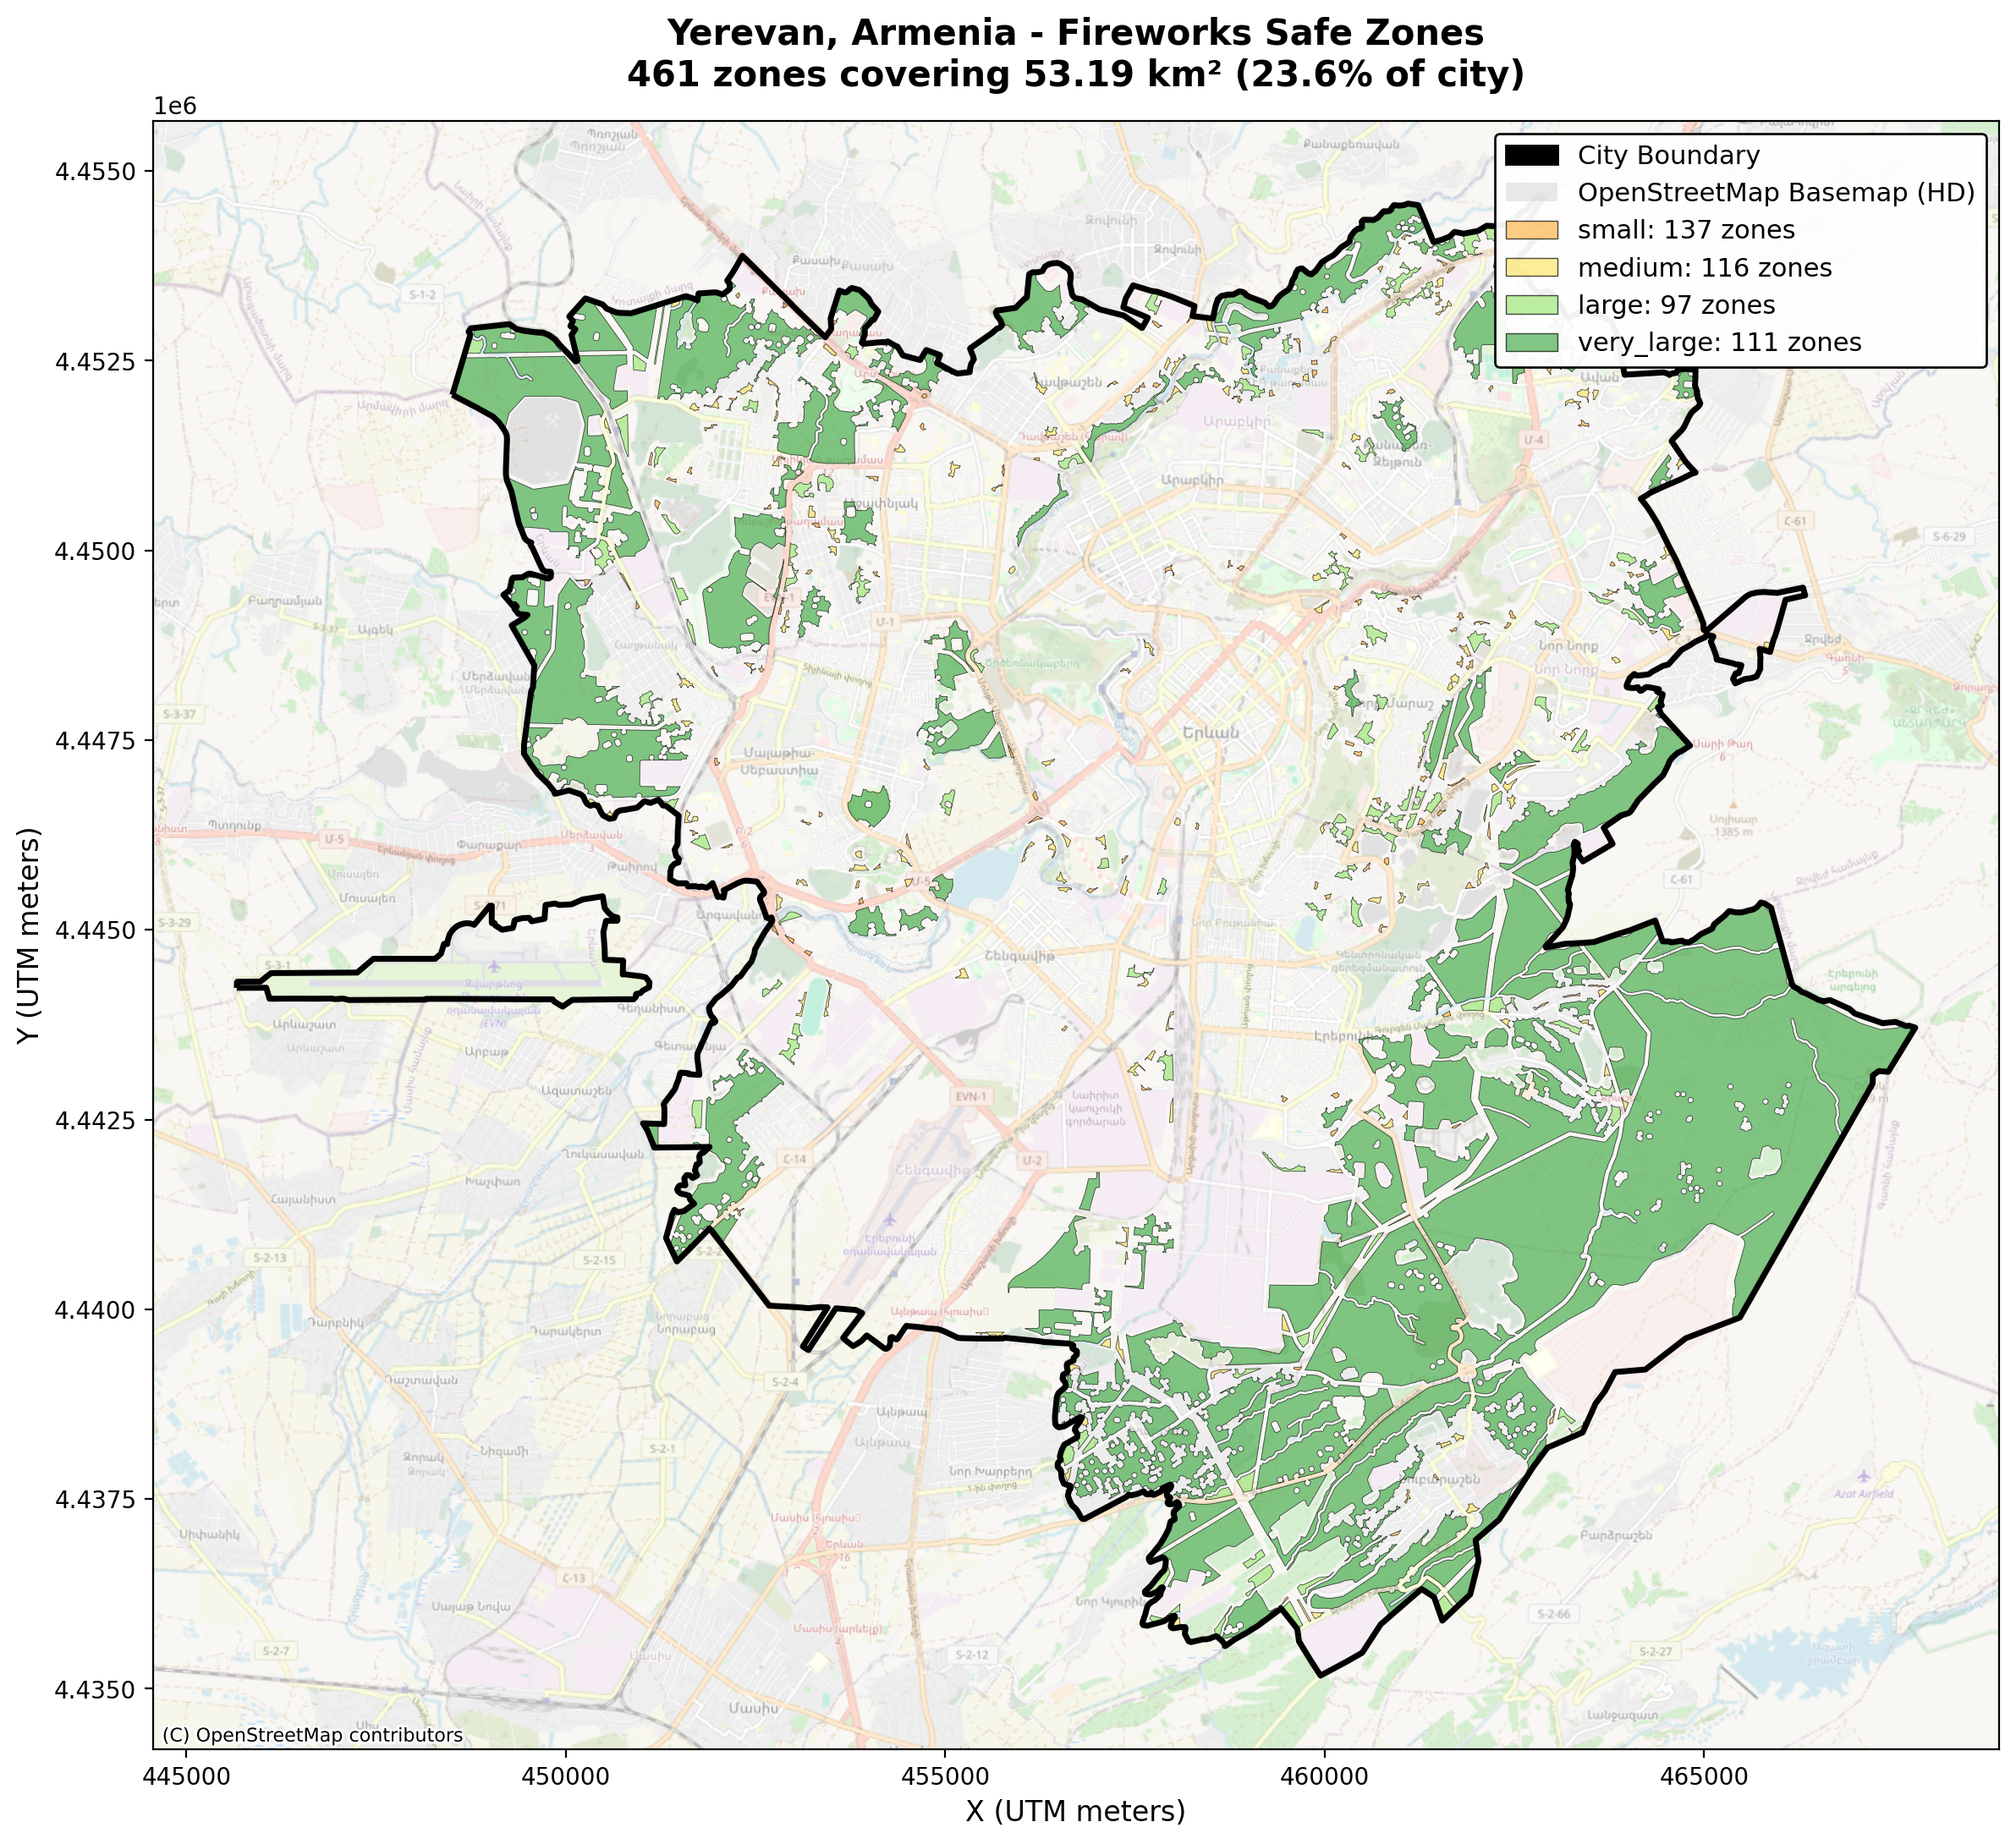

Map rendered: 1400x1100px @ zoom 13 (high detail)


In [13]:
# Use higher zoom tiles for sharper basemap
fig, ax = plt.subplots(figsize=(14, 11), dpi=100)

# Plot safe zones FIRST to establish axis limits
print("Plotting zones...")
# Color scheme matching KML/visualizations (orange → yellow → green)
size_colors = {
    'small': '#FFB84D',      # Orange (2-5k m²)
    'medium': '#FFE66D',     # Yellow (5-12.5k m²)
    'large': '#A0E87C',      # Light green (12.5-50k m²)
    'very_large': '#4CAF50'  # Green (50k+ m²)
}

for size_class, color in size_colors.items():
    subset = zones_utm[zones_utm['size_class'] == size_class]
    if len(subset) > 0:
        subset.plot(ax=ax, facecolor=color, edgecolor='black',
                   alpha=0.7, linewidth=0.3, zorder=3)

# Plot boundary
boundary_utm.boundary.plot(ax=ax, color='black', linewidth=2.5, zorder=5)

# Get current axis limits BEFORE adding basemap
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add OpenStreetMap basemap with HIGHER zoom (13 or 14) for much sharper tiles
# The tiles will be downloaded at higher resolution and scaled down = sharper!
print("Downloading high-resolution OpenStreetMap basemap tiles (zoom 13)...")
cx.add_basemap(ax, crs=TARGET_CRS, source=cx.providers.OpenStreetMap.Mapnik, 
               alpha=0.5, zorder=1, zoom=13)

# Restore axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Title and labels
ax.set_title(
    f'{CITY} - Fireworks Safe Zones\n'
    f'{total_zones} zones covering {safe_area_km2:.2f} km² ({coverage_pct:.1f}% of city)',
    fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('X (UTM meters)', fontsize=12)
ax.set_ylabel('Y (UTM meters)', fontsize=12)

# Legend
legend_elements = [
    Patch(facecolor='black', edgecolor='black', label='City Boundary'),
    Patch(facecolor='lightgray', alpha=0.5, label='OpenStreetMap Basemap (HD)')
]
for size_class, color in size_colors.items():
    count = len(zones[zones['size_class'] == size_class])
    if count > 0:
        legend_elements.append(
            Patch(facecolor=color, alpha=0.7, edgecolor='black', linewidth=0.5,
                  label=f'{size_class}: {count} zones')
        )
ax.legend(handles=legend_elements, loc='upper right', fontsize=11,
          framealpha=0.95, edgecolor='black')

ax.set_aspect('equal')
plt.tight_layout()
plt.show()
print(f"Map rendered: {14*100}x{11*100}px @ zoom 13 (high detail)")

## Top Zones Analysis

In [14]:
# Show top 10 largest zones
top_zones = zones.nlargest(10, 'area_m2')

print("Top 10 largest safe zones:\n")
for idx, row in top_zones.iterrows():
    area_ha = row['area_m2'] / 10_000
    # Use pre-calculated centroid coordinates from metadata (already in WGS84)
    print(f"  Zone #{row['zone_id']:3d}: {area_ha:7.2f} ha ({row['size_class']:10s}) "
          f"- {row['centroid_y']:.5f}°N, {row['centroid_x']:.5f}°E")

Top 10 largest safe zones:

  Zone # 34:  979.31 ha (very_large) - 4442265.68466°N, 465265.93016°E
  Zone #327:  317.34 ha (very_large) - 4441187.98984°N, 462730.87609°E
  Zone #329:  245.96 ha (very_large) - 4439864.46525°N, 460903.24152°E
  Zone # 33:  132.03 ha (very_large) - 4444353.82678°N, 465140.18380°E
  Zone #  8:  131.82 ha (very_large) - 4452717.68389°N, 452007.95103°E
  Zone #252:  118.85 ha (very_large) - 4438427.25287°N, 459827.56237°E
  Zone # 56:  118.42 ha (very_large) - 4452087.66537°N, 449517.96315°E
  Zone # 53:  113.26 ha (very_large) - 4448357.05235°N, 450095.04016°E
  Zone # 29:  112.38 ha (very_large) - 4446719.76185°N, 463547.79402°E
  Zone # 47:  105.66 ha (very_large) - 4442121.24407°N, 452125.99990°E


## Export Results

In [15]:
from pathlib import Path
from src.exporters import export_zones_to_geojson, export_zones_to_csv

output_dir = Path('../data')
output_dir.mkdir(exist_ok=True)

geojson_path = export_zones_to_geojson(zones, output_dir, city_name=CITY, target_crs=TARGET_CRS)
csv_path = export_zones_to_csv(zones, output_dir)

print("Results exported:")
print(f"  GeoJSON: {geojson_path}")
print(f"  CSV: {csv_path}")

Results exported:
  GeoJSON: ../data/yerevan-armenia/safe_zones.geojson
  CSV: ../data/unknown-city/safe_zones.csv


## Summary

In [16]:
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)

print("\nTerritory:")
print(f"  City area:        {boundary_area_km2:.2f} km²")
print(f"  Safe area:        {safe_area_km2:.2f} km² ({coverage_pct:.1f}%)")
print(f"  Excluded:         {boundary_area_km2 - safe_area_km2:.2f} km² ({100-coverage_pct:.1f}%)")

print("\nObstacles:")
print(f"  Total features:   {total_features:,}")
print(f"  Categories:       {non_empty_cats} active (39 total)")
print(f"  Buffer range:     {min(buffers.values()):.0f}-{max(buffers.values()):.0f} meters")

print("\nSafe zones:")
print(f"  Total zones:      {total_zones}")
print(f"  Size range:       {zones['area_m2'].min()/10000:.2f} - {zones['area_m2'].max()/10000:.2f} ha")
print(f"  Average area:     {zones['area_m2'].mean()/10000:.2f} ha")
print(f"  Avg compactness:  {zones['compactness'].mean():.3f}")

print("\n" + "="*70)

ANALYSIS SUMMARY

Territory:
  City area:        225.79 km²
  Safe area:        53.19 km² (23.6%)
  Excluded:         172.59 km² (76.4%)

Obstacles:
  Total features:   85,201
  Categories:       38 active (39 total)
  Buffer range:     20-1500 meters

Safe zones:
  Total zones:      461
  Size range:       0.20 - 979.31 ha
  Average area:     11.54 ha
  Avg compactness:  0.341

